In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Deterministic Model

Consider a model for the spread of a virus in a population consisting of 3 parts: # of Susceptible individuals ($S$), # Infectious ($I$), and # Recovered ($R$), satisfying the following dynamics

$
\frac{dS}{dt} = -\frac{\beta I S}{N}\\
\frac{dI}{dt} = \frac{\beta I S}{N} - \gamma I\\
\frac{dR}{dt} = \gamma I\\
$
Where $N=S+I+R$, $\gamma^{-1}$= recovery time, and $\beta^{-1}$=time between transmission contacts.
Note that $\frac{dN}{dT} = 0$, so we need only integrate 2 of the equations.
Now we de-dimensionalize the equations in terms of the transmission time $\tau=\gamma t$ and the reproduction ratio $R_0=\frac{\beta}{\gamma}$=expected number of new infections transmitted by a single infection in a fully susceptible population.
$
\frac{dS}{d\tau} = -\frac{R_0 I S}{N}\\
\frac{dI}{d\tau} = (\frac{R_0 S}{N} - 1)I\\
\frac{dR}{d\tau} = I\\
$

In [38]:
N=1000.0
#equations of motion
def Sdot(S, I, R0):
    return -R0*S*I/N
    
def Idot(S, I, R0):
    return I*(R0*S/N - 1)

#first order integrator
def integrate(S0, I0, R0, T):
    dt = 1e-2
    S=np.zeros(T); S[0] = S0
    I=np.zeros(T); I[0] = I0
    for i in np.arange(1, T):
        S[i] = S[i-1] + dt*Sdot(S[i-1], I[i-1], R0)
        I[i] = I[i-1] + dt*Idot(S[i-1], I[i-1], R0)
    return (S, I)

Simulate the dynamics using the Euler method. We plot the results below over a range of values for the reproduction rate. Note that if initially $\frac{R_{0}S_0}{N} < 1$ the infected population never has a chance to grow, as can be seen easily from the second ODE.

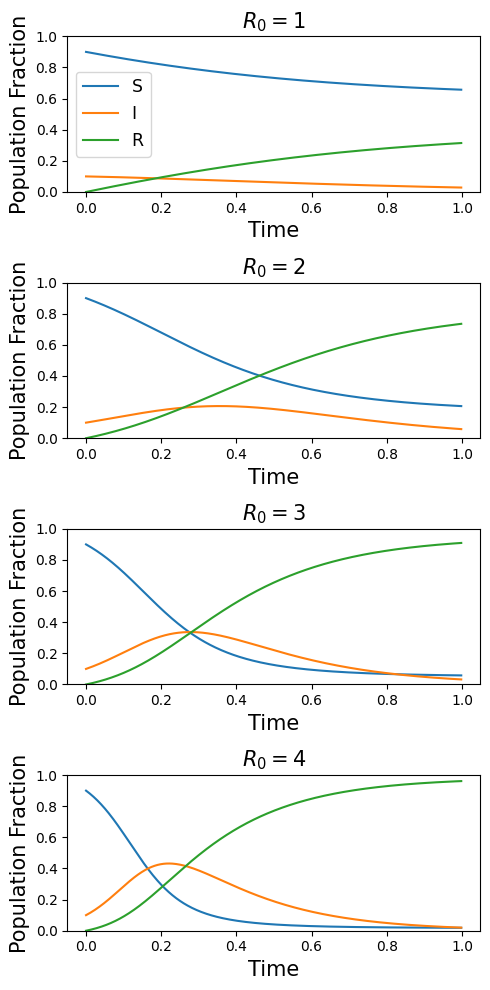

In [135]:
fig, ax = plt.subplots(4, 1, figsize=(5,10))


for i, R0 in enumerate(np.arange(1,5)):
    tmpS, tmpI = integrate(900, 100, R0, 500)
    ax[i].plot(np.arange(500)/500, tmpS/N, label='S')
    ax[i].plot(np.arange(500)/500, tmpI/N, label='I')
    ax[i].plot(np.arange(500)/500, (N-tmpS-tmpI)/N, label='R')
    ax[i].set_ylim([0,1])
    ax[i].set_xlabel("Time", fontsize=15)
    ax[i].set_ylabel("Population Fraction", fontsize=15)
    ax[i].set_title("$R_0={}$".format(R0), fontsize=15)
    
ax[0].legend(fontsize=12.5)
fig.tight_layout()

## Stochastic Simulation Model

We can replace the continuous dynamical systems model above with a more realistic stochastic model with discrete events.

The probability of an infection occuring in the time interval $d\tau$ is
$
P_{infection} = \frac{R_0 I S}{N} d\tau\\
$
and the probability of a recovery occuring in that time interval is
$
P_{recovery} = I d\tau\\
$
The result of these events would respectively give $S\rightarrow S-1, I\rightarrow I+1$ and $I\rightarrow I-1, R\rightarrow R+1$. Although directly computing the distribution of states from the Master Equation after a finite time would be intractibly hard, we can simulate stochastic trajectories using the Gillespie algorithm. We show the results of a stochastic simulation below, and compare the results to the exact integration from above.

In [107]:
def G_step(S, I, R0):
    #compute reaction rates
    a_infection = R0*I*S/N
    a_recovery = I
    a0 = a_infection+a_recovery
    #compute reaction and time using inverse sampling
    tau = np.log(1/np.random.uniform())/a0
    j = np.random.choice([0,1],p=[a_infection/a0, a_recovery/a0])
    #j=0 corresponds to infection, j=1 to recovery
    return tau, j

def gillespie_trajectory(S0, I0, R0):
    time = [0]
    S=[S0]
    I=[I0]
    R=[N-S0-I0]
    while(I[-1] > 0):
        t, j = G_step(S[-1], I[-1], R0)
        time.append(time[-1]+t)
        S.append(S[-1] - (1-j))
        I.append(I[-1] + (1-2*j))
        R.append(R[-1] + j)
    return S, I, R, time

In [127]:
GS, GI, GR, GT = gillespie_trajectory(900, 100, 5.0)

In [131]:
igS, igI = integrate(900, 100, 5.0, int(GT[-1]/1e-2))

Text(0.5, 0, '$\\tau$')

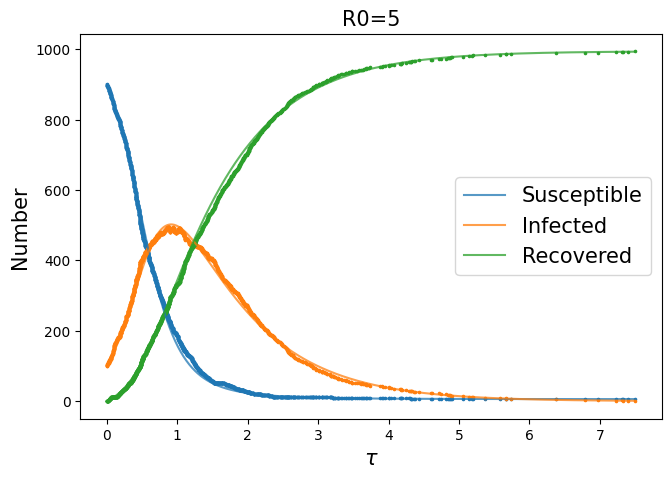

In [140]:
fig, ax = plt.subplots(figsize=(7.5,5))
nT = int(GT[-1]/1e-2)
ax.scatter(GT, GS, s=2.5)
ax.plot(GT[-1]*np.arange(nT)/nT, igS, alpha=0.75, label='Susceptible')
ax.scatter(GT, GI, s=2.5)
ax.plot(GT[-1]*np.arange(nT)/nT, igI, alpha=0.75, label='Infected')
ax.scatter(GT, GR, s=2.5)
ax.plot(GT[-1]*np.arange(nT)/nT, N-igS-igI, alpha=0.75, label='Recovered')

ax.legend(fontsize=15)
ax.set_title('R0=5', fontsize=15)
ax.set_ylabel('Number', fontsize=15)
ax.set_xlabel('$\\tau$', fontsize=15)

We will now consider a more complex model within this stochastic framework that includes births and deaths. Our model will now include the following set of events:
$
a_{infection} = \frac{R_0 I S}{N}, S\rightarrow S-1, I\rightarrow I+1 \\
a_{recovery} = I, I\rightarrow I-1, R\rightarrow R+1\\
a_{susbirth} = m(S+I+R), S\rightarrow S+1\\
a_{susdeath} = mS, S\rightarrow S-1\\
a_{infdeath} = mI, I\rightarrow I-1\\
a_{recdeath} = mR, R\rightarrow R-1\\
a_{viraldeath} = vI, I\rightarrow I-1\\
$
As before we have infection and recovery, but have now added natural births and deaths, as well as virus induced deaths. As before we can simulate the stochastic dynamics with the Gillespie algorithm.

In [178]:
def G_BD_step(S, I, R, R0, m, v):
    #compute reaction rates
    a_infection = R0*I*S/N
    a_recovery = I
    a_sb = m*(S+I+R)
    a_sd = m*S
    a_id = m*I
    a_rd = m*R
    a_vd = v*I
    a0 = a_infection + a_recovery + a_sb + a_sd + a_id + a_rd + a_vd
    #compute reaction and time using inverse sampling
    tau = np.log(1/np.random.uniform())/a0
    probs = np.asarray([a_infection, a_recovery, a_sb, a_sd, a_id, a_rd, a_vd])/a0
    j = np.random.choice([0,1,2,3,4,5,6], p=probs)
    return tau, j

def gillespie_BD_trajectory(S0, I0, R0, m, v, Nstep=1000):
    time = [0]
    S=[S0]
    I=[I0]
    R=[N-S0-I0]
    for t in np.arange(Nstep):
        t, j = G_BD_step(S[-1], I[-1],R[-1], R0, m, v)
        time.append(time[-1]+t)
        if j==0:
            S.append(S[-1] - 1)
            I.append(I[-1] + 1)
            R.append(R[-1])
        elif j==1:
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1] + 1)
        elif j==2:
            S.append(S[-1] + 1)
            I.append(I[-1])
            R.append(R[-1])
        elif j==3:
            S.append(S[-1] - 1)
            I.append(I[-1])
            R.append(R[-1])
        elif j==4:
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1])
        elif j==5:
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1] - 1)
        elif j==6:
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1])
    return S, I, R, time

In [185]:
example_BD = gillespie_BD_trajectory(900, 100, 10.0, 1.0, 0.0, 15000)

Consider the following example of a non-fatal disease with $v=0, R_0=10$, and $m=1$. Since new susceptible hosts are added to the population the infection is able to sustain itself instead of running through all of the suceptible hosts and dying out. This more realistic behavior could also be achieved in a simpler model where there is a probability that recovered individuals lose immunity and revert to being susceptible.

Text(0.5, 0, '$\\tau$')

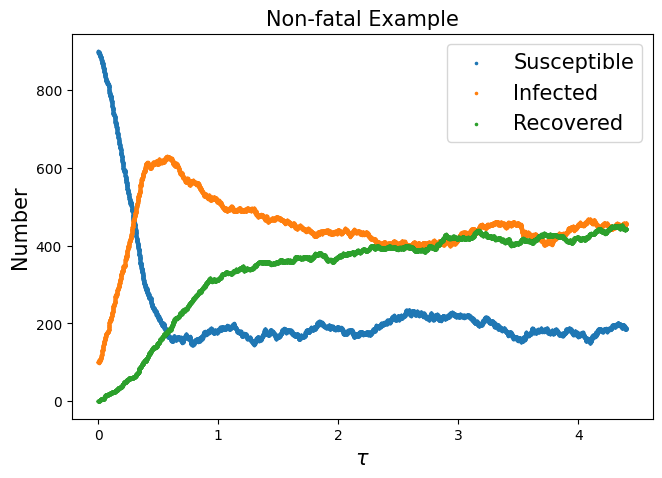

In [187]:
fig, ax = plt.subplots(figsize=(7.5,5))
ax.scatter(example_BD[-1], example_BD[0], s=2.5, label='Susceptible')
ax.scatter(example_BD[-1], example_BD[1], s=2.5, label='Infected')
ax.scatter(example_BD[-1], example_BD[2], s=2.5, label='Recovered')

ax.legend(fontsize=15)
ax.set_title('Non-fatal Example', fontsize=15)
ax.set_ylabel('Number', fontsize=15)
ax.set_xlabel('$\\tau$', fontsize=15)

In [201]:
modfatal_BD = gillespie_BD_trajectory(900, 100, 10.0, 1.0, 0.2, 25000)

Now consider a moderately fatal disease with $v=0.2, R_0=10$, and $m=1$. As before the virus is able to sustain itself in the population but at a much lower fraction of the population.

Text(0.5, 0, '$\\tau$')

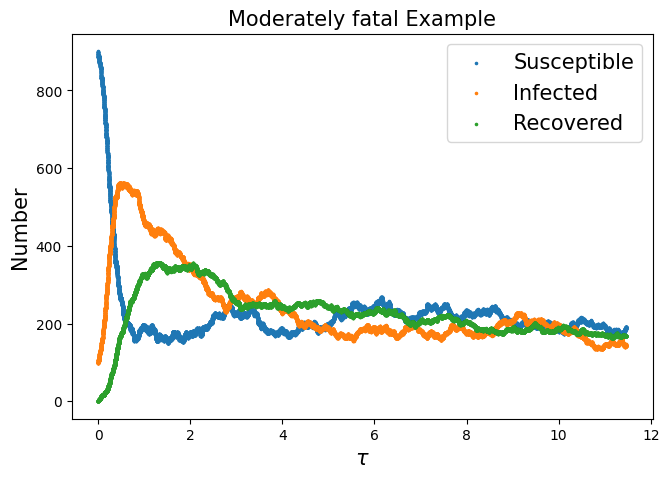

In [202]:
fig, ax = plt.subplots(figsize=(7.5,5))
ax.scatter(modfatal_BD[-1], modfatal_BD[0], s=2.5, label='Susceptible')
ax.scatter(modfatal_BD[-1], modfatal_BD[1], s=2.5, label='Infected')
ax.scatter(modfatal_BD[-1], modfatal_BD[2], s=2.5, label='Recovered')

ax.legend(fontsize=15)
ax.set_title('Moderately fatal Example', fontsize=15)
ax.set_ylabel('Number', fontsize=15)
ax.set_xlabel('$\\tau$', fontsize=15)

In [203]:
stronglyfatal_BD = gillespie_BD_trajectory(900, 100, 10.0, 1.0, 1.0, 25000)

Finally consider a strongly fatal virus with $v=1.0, R0=10$, and $m=1$. the increased death rate from the viral mortality is too strong and the virus is not able to sustain itself in the population. Thus we see that fatality is  an adverse quality for a virus.

Text(0.5, 0, '$\\tau$')

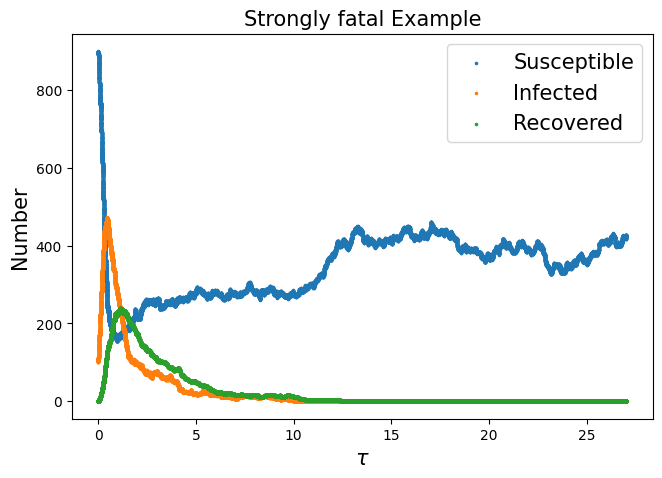

In [205]:
fig, ax = plt.subplots(figsize=(7.5,5))
ax.scatter(stronglyfatal_BD[-1], stronglyfatal_BD[0], s=2.5, label='Susceptible')
ax.scatter(stronglyfatal_BD[-1], stronglyfatal_BD[1], s=2.5, label='Infected')
ax.scatter(stronglyfatal_BD[-1], stronglyfatal_BD[2], s=2.5, label='Recovered')

ax.legend(fontsize=15)
ax.set_title('Strongly fatal Example', fontsize=15)
ax.set_ylabel('Number', fontsize=15)
ax.set_xlabel('$\\tau$', fontsize=15)